# MILESTONE 2

IMDB dataset + Siraj's Network

In [1]:
import numpy as np
import tensorflow as tf
import re
from collections import Counter
import json
from pprint import pprint

In [2]:
def get_vocab(sentences):
    words = []
    for each in sentences:
        each = each.lower()
        words_this_sentence = each.split(' ')
        words.extend(words_this_sentence)
    vocab = set(words)
    return vocab

In [3]:
sentence = []
score = []

In [4]:
with open('beam_cable_google_tagged_data.json') as data_file:
    data1 = json.load(data_file)
with open('droom_google_tagged_data.json') as data_file:
    data2 = json.load(data_file)
for d in data1['data']:
    conversation = d['conversation']
    c_id = d['conversation_id']
    for c in conversation:
        sentiment = float(c['sentiment'])
        sentiment = -1 if (sentiment < 0) else 1
        dialogue = c['text']
        sentence.append(dialogue)
        score.append(sentiment)

for d in data2['data']:
    conversation = d['conversation']
    c_id = d['conversation_id']
    for c in conversation:
        sentiment = float(c['sentiment'])
        sentiment = -1 if (sentiment < 0) else 1
        dialogue = c['text']
        sentence.append(dialogue)
        score.append(sentiment)

# sentence.extend(dialogues)
# score.extend(sentiments)


In [ ]:
vocab_chat = list(get_vocab(sentence))
# print(len(vocab_chat), vocab)

In [ ]:
filename = 'Embedding_models/glove.6B.300d.txt'
def loadGloVe(filename):
    vocab = []
    embd = []
    file = open(filename,'r')
    for line in file.readlines():
        row = line.strip().split(' ')
        vocab.append(row[0])
        embd.append(row[1:])
    print('Loaded GloVe!')
    file.close()
    return vocab,embd
vocab,embd = loadGloVe(filename)
vocab_size = len(vocab)
embedding_dim = len(embd[0])
embedding = np.asarray(embd)

In [ ]:
total = 0
for each in sentence:
    total = total + len(each.split(' '))
avg = total/len(sentence)
print (avg)

In [ ]:
from tensorflow.contrib import learn
#init vocab processor
max_document_length = 20
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
#fit the vocab from glove
pretrain = vocab_processor.fit(vocab)
#transform inputs
input_x = np.array(list(vocab_processor.transform(sentence)))
print(np.shape(input_x))

In [ ]:
# max_document_length = 1
# vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
# #fit the vocab from glove
# pretrain = vocab_processor.fit(vocab)
# #transform inputs
# all_w = []
# total = 0
# for each in vocab_chat:
#     total = total+1
#     input_x = np.array(list(vocab_processor.transform([each])))
# #     print (input_x[0][0])
#     if input_x[0][0] == 0:
#         all_w.append(each)
# print (total)
# print (len(all_w))
# with open('words_not_in_glove.txt','w') as out:
#     out.write(str(all_w))
            
        
# # print(np.shape(input_x))


In [4]:
############# NEW GLOVE ################

W = tf.Variable(tf.constant(0.0, shape=[vocab_size, embedding_dim]),
                trainable=False, name="W")
embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
embedding_init = W.assign(embedding_placeholder)

#######################################




NameError: name 'vocab_size' is not defined

## Train Test Validation split

In [11]:
split_frac = 0.6
split_idx = int(len(sentence)*split_frac)

dialogues_train, dialogues_val = input_x[:split_idx], input_x[split_idx:]
sentiments_train, sentiments_val = score[:split_idx], score[split_idx:]

test_idx = int(len(dialogues_val)*0.5)
dialogues_val, dialogues_test = dialogues_val[:test_idx], dialogues_val[test_idx:]
sentiments_val, sentiments_test = sentiments_val[:test_idx], sentiments_val[test_idx:]

In [12]:
train_x = []
val_x = []
train_y = []
val_y = []

# train_x.extend(reviews_train)
train_x.extend(dialogues_train)

# train_y.extend(labels_train)
train_y.extend(sentiments_train)

In [13]:
from random import shuffle
train = list(zip(train_x, train_y))
shuffle(train)

train_x = [ item[0] for item in train]
train_y = [ [item[1]] for item in train]

sentiments_val = [ [item] for item in sentiments_val]
sentiments_test = [ [item] for item in sentiments_test]

## Building Network

In [2]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
#hidden_nodes = 10
n_epochs = 1

X = tf.placeholder(tf.int32, [None, None], name = 'inputs')
Y = tf.placeholder(tf.float32, [None, 1], name = 'labels')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

tf.set_random_seed(5)

In [3]:
#embed = tf.nn.embedding_lookup(W, X)
# print (embed)
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

cell = tf.contrib.rnn.MultiRNNCell([lstm]*lstm_layers)

#getting an initial state of zeros\n",
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

predictions = tf.contrib.layers.fully_connected(outputs[:, -1],1, activation_fn=tf.tanh)

loss = tf.reduce_mean(tf.square(Y - predictions))
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

ValueError: None values not supported.

In [16]:
#Accuracy:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [17]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_train_acc = []
global_test_acc = []

global_train_loss = []
global_test_loss = []

global_val_chat_loss = []

saver = tf.train.Saver()
min_loss = 1.0

import time
start_time = time.time()
sess.run(tf.global_variables_initializer())
sess.run(embedding_init, feed_dict={embedding_placeholder: embedding})
for e in range(n_epochs):
    state = sess.run(initial_state)
    iteration = 1
    temp_train_loss = []
    for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
        feed = {X: x, Y: y, initial_state: state}

        state, loss_,  _ = sess.run([final_state, loss, optimizer], feed_dict=feed)

        if iteration%50==0:
            print("Epoch: {}/{}".format(e, n_epochs),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss_))
        temp_train_loss.append(loss_)
        
        if iteration%200==0:
                val_acc = []
                val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for x, y in get_batches(dialogues_val, sentiments_val, batch_size):
                    feed = {X: x,
                            Y: y,
                            initial_state: val_state}
                    batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                    val_acc.append(batch_acc)
                print("Val acc: {:.5f}".format(np.mean(val_acc)))
                
                train_acc = []

                train_state = sess.run(cell.zero_state(batch_size, tf.float32))
                for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                    feed = {X: x,Y: y,initial_state: train_state}

                    batch_acc, train_state = sess.run([accuracy, final_state], feed_dict=feed)
                    train_acc.append(batch_acc)

                print("Train accuracy: {:.5f}".format(np.mean(train_acc)))
        
        '''
        if loss_<min_loss:
            min_loss = loss_
            save_path = saver.save(sess, "/model.ckpt")
        '''
        iteration+=1
    global_train_loss.append(np.mean(temp_train_loss))
    
    
    ##Validation loss Chat
    val_loss = []
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for x, y in get_batches(dialogues_val, sentiments_val, batch_size):
        feed = {X: x,
                Y: y,
                initial_state: val_state}
        loss_, val_state = sess.run([loss, final_state], feed_dict=feed)
        val_loss.append(loss_)
    global_val_chat_loss.append(np.mean(val_loss))
    
#sess.close()
    
print('Training Completed')
print('Total Time Taken: '+str(time.time()-start_time)+' sec' )

Epoch: 0/1 Iteration: 50 Train loss: 2.75200
Epoch: 0/1 Iteration: 100 Train loss: 2.56800
Epoch: 0/1 Iteration: 150 Train loss: 2.80800
Epoch: 0/1 Iteration: 200 Train loss: 2.76000
Val acc: 0.29363
Train accuracy: 0.30720
Epoch: 0/1 Iteration: 250 Train loss: 2.89600
Epoch: 0/1 Iteration: 300 Train loss: 2.80000
Epoch: 0/1 Iteration: 350 Train loss: 2.59200
Epoch: 0/1 Iteration: 400 Train loss: 2.64800
Val acc: 0.29363
Train accuracy: 0.30720
Epoch: 0/1 Iteration: 450 Train loss: 2.75200
Epoch: 0/1 Iteration: 500 Train loss: 2.72000
Epoch: 0/1 Iteration: 550 Train loss: 2.84800
Epoch: 0/1 Iteration: 600 Train loss: 2.91200
Val acc: 0.29363
Train accuracy: 0.30720
Epoch: 0/1 Iteration: 650 Train loss: 2.72800
Epoch: 0/1 Iteration: 700 Train loss: 2.65600
Epoch: 0/1 Iteration: 750 Train loss: 2.79200
Epoch: 0/1 Iteration: 800 Train loss: 2.74400
Val acc: 0.29363
Train accuracy: 0.30720
Epoch: 0/1 Iteration: 850 Train loss: 2.65600
Training Completed
Total Time Taken: 151.97952008247375

## Test Accuracy

In [19]:
'''
saver = tf.train.Saver()
saver.restore(sess, "/model.ckpt")
'''


test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(dialogues_test, sentiments_test, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Test acc for chat : {:.5f}".format(np.mean(test_acc)))

Test acc for chat : 0.34712


## Training - Test Curve

[2.7691255]
[2.8254867]


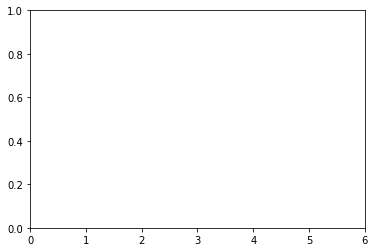

In [20]:
print(global_train_loss)

print(global_val_chat_loss)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()
x = range(n_epochs) 
plt.axis([0,len(x)+5,0,1])
plt.plot(x,global_train_loss,'go',x,global_val_chat_loss,'bo')
plt.show()

#print('Minimum Testing Loss: '+str(np.min(global_test_loss)) )